# Handwritten Chinese Digit Recognizer

## [Dataset](https://www.kaggle.com/gpreda/chinese-mnist) 15000 64x64 .jpg


### charactors
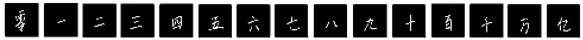

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
import skimage

## Prepare Dataset

In [ ]:
# load dataset
df= pd.read_csv("/kaggle/input/chinese-mnist/chinese_mnist.csv", low_memory = False)
df.head()

In [ ]:
print("dataframe rows:", df.shape[0]) 
print("image files :", len(os.listdir("/kaggle/input/chinese-mnist/data/data/")))

In [ ]:
# Matchin image names
def file_path_col(df):    
    file_path = f"input_{df[0]}_{df[1]}_{df[2]}.jpg" #input_1_1_10.jpg    
    return file_path

# Create file_path column
df["file_path"] = df.apply(file_path_col, axis = 1)
df.head()

### split dataset

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = df.code.values)
val_df, test_df   = train_test_split(df, test_size = 0.5, random_state = 42, shuffle = True, stratify = df.code.values)

print(train_df.shape[0])
print(val_df.shape[0])
print(test_df.shape[0])

In [ ]:
import skimage.io
import skimage.transform

file_paths = list(df.file_path)
def read_image(file_paths):
    image = skimage.io.imread("/kaggle/input/chinese-mnist/data/data/" + file_paths)
    image = skimage.transform.resize(image, (64, 64, 1), mode="reflect") 
    # THe mode parameter determines how the array borders are handled.    
    return image[:, :, :]

# One hot encoder, but in 15 classes
def character_encoder(df, var = "character"):
    x = np.stack(df["file_path"].apply(read_image))
    y = pd.get_dummies(df[var], drop_first = False)
    return x, y

In [ ]:
x_train, y_train = character_encoder(train_df)
x_val, y_val = character_encoder(val_df)
x_test, y_test = character_encoder(test_df)

print(x_train.shape, ",", y_train.shape)
print(x_val.shape, ",", y_val.shape)
print(x_test.shape, ",", y_test.shape)

## Build Model

In [ ]:
input_shape = (64,64,1) # img_rows, img_colums, color_channels
num_classes = y_train.shape[1] # charactors = 15 

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()
# 1st Conv layer
model.add(layers.Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
# 2nd Conv layer        
model.add(layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
# 3nd Conv layer        
model.add(layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
# Fully Connected layer        
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation = 'softmax'))

model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

## Train Model

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

### save model

In [ ]:
model.save('chinese-mnist.h5')

## Evaluate Model

In [ ]:
# Evaluate Model
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

### show training history

In [ ]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,test): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[test])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')